1. Overview
----------------------

This project aims to analyze variations in labor market conditions, education, and demographics across Austrian municipalities, specifically examining differences between villages, towns, cities, and Vienna. The analysis utilizes data on Austria's 2,207 municipalities collected by Statistics Austria in 2019.

__Methodology__
After categorizing municipalities by size (villages, towns, cities, and Vienna), the analysis involved computing means across these categories using one-way ANOVA tests at a 95 percent confidence level.

__Results__
- There are statistically significant differences between categories of municipalities in mean employment, unemployment, commuting patterns, non-Austrian citizenship, and educational levels (P<.05)
- Villages and towns show higher employment rates; cities, including Vienna, have elevated unemployment
- Villages have a higher rate of secondary education attainment while larger urban areas have rates of tertiary education attainment
- Villages tend to have larger household size while cities had a higher proportion of  non-Austrian citizens.

__Data source__

STATISTIK AUSTRIA. (2022-10-27). "AEST_Gemeindeergebnisse_2012-2019.ods," (File). Reference Number: Q: 649 57 834. Accessed on October 27, 2022, from https://www.statistik.at/en/statistics/labour-market/unemployment/unemployed-seeking-work

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [67]:
#set up the working environment
# Read the CSV file into a DataFrame
AustriaCensus2019 = pd.read_csv('AustriaCensus2019.csv') 

# Give cols more clear names
AustriaCensus2019 = AustriaCensus2019.rename(columns={
    'Community Code': 'Code',
    'Bundesland, Politischer Bezirk, Gemeinde': 'District',
    'total population': 'Total_population',
    'Proportion of people\r\n under 15 years': 'Proportion_under_15',
    'Proportion of people\r\n 65 years and older': 'Proportion_65_and_older',
    'share of non-Austrian citizens': 'Share_non_Austrian_citizens',
    'employment rate\r\n of 15 to 64 year olds': 'Employment_rate_15_to_64',
    'unemployment rate\r\n (15 years and older)': 'Unemployment_rate_15_and_older',
    'Share of people with secondary education ': 'Share_secondary',
    'Share of people with tertiary education ': 'Share_tertiary',
    'Share of commuters in active employment': 'Share_commuters',
    'Number of private households': 'Number_private_households',
    'average household size': 'Average_household_size',
    ' Number of families ': 'Number_of_families',
    'Companies ': 'Number_of_companies',
    'Workplaces ': 'Number_of_workplaces',
    'Employees in the workplaces': 'Number_of_employees'
})


# Fix column names with line breaks
AustriaCensus2019 = AustriaCensus2019.rename(columns={
    'Proportion of people\n under 15 years': 'Proportion_under_15',
    'Proportion of people\n 65 years and older': 'Proportion_65_and_older',
    'employment rate\n of 15 to 64 year olds': 'Employment_rate_15_to_64',
    'unemployment rate\n (15 years and older)': 'Unemployment_rate_15_and_older'
})

# Clean the data to ensure that the variables are appropriately categorized

# Category
AustriaCensus2019['District'] = AustriaCensus2019['District'].astype('category')


# Floats
columns_to_convert = [
    'Code', 'Proportion_under_15', 'Proportion_65_and_older',
    'Share_non_Austrian_citizens', 'Employment_rate_15_to_64',
    'Unemployment_rate_15_and_older'
]

# Convert to floats using .loc to avoid SettingWithCopyWarning
AustriaCensus2019.loc[:, columns_to_convert] = AustriaCensus2019[columns_to_convert].astype('float')

# Integers
AustriaCensus2019['Total_population'] = AustriaCensus2019['Total_population'].astype('int')


2.1 Slicing by Population and Intial Analysis
----------------------

After cleaning and formatting the data I had a dataframe with 2,207 municipalities. I then created a variable that categorized the municipalities based on their positions in the percentile order of population size:

__Village (1048 total)__

Definition: Municipalities falling within the bottom 50% of the total population distribution.
Range: 42 to 1,813 residents.

__Town (1027 total)__

Definition: Municipalities falling within the top 50% to the 99.99th percentile of the total population distribution.
Range: 1,814 to 23,841 residents.

__City (22 total)__

Definition: Municipalities falling within the 99.99th to 100th percentile of the total population distribution excluding Vienna. This category includes some of the largest municipalities in Austria, such as Graz, Innsbruck, and Linz.
Range: 24,473 to 290,540 residents.

__Vienna__

Definition: A specific category for the city of Vienna, which stands as the largest city in Austria with a population of 1,908,104.

The pie chart reveals that over 25% of Austrians live in cities, notably with Vienna being home to a significant portion of the overall population. Additionally, less than 40% of the population resides in towns and villages within the bottom 99th percentile in Austria.

In [68]:
# Categorize cases
total_population_quartiles = pd.qcut(AustriaCensus2019['Total_population'], q=[0, 0.5, .99, .9999, 1], labels=['Village', 'Town', 'City', 'Vienna'])
AustriaCensus2019['Population_category'] = total_population_quartiles.astype('category')

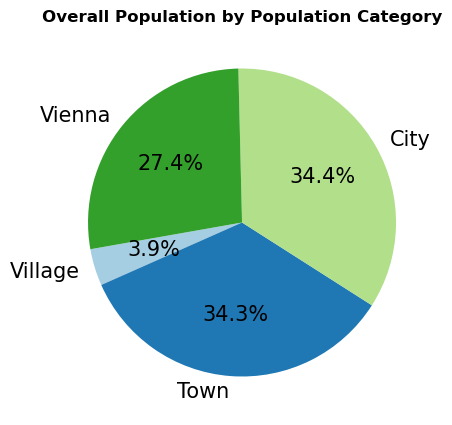

In [69]:
# Generate a pie chart
# Calculate total population for each category
population_by_category = AustriaCensus2019.groupby('Population_category')['Total_population'].sum()

# Create a pie chart using the calculated data
plt.figure(figsize=(5, 5))
plt.pie(population_by_category, labels=population_by_category.index, autopct='%1.1f%%', startangle=190, colors=sns.color_palette('Paired'), textprops={'fontsize': 15,})
plt.title('Overall Population by Population Category', fontweight='bold')
plt.show()

In [70]:
# Get the range of residents by population category
category_ranges = AustriaCensus2019.groupby('Population_category')['Total_population'].agg(['min', 'max'])
print("Population Range by Category")
print(category_ranges)
print("\n\n")
# Get the number of cases by population category
cases_by_category = AustriaCensus2019['Population_category'].value_counts().reset_index()
cases_by_category.columns = ['Population_category', 'Number_of_Cases']
print("Number of Cases by Category")
print(cases_by_category)
print("\n")

Population Range by Category
                         min      max
Population_category                  
Village                   42     1930
Town                    1932   132095
City                  134872  1908104
Vienna               8894380  8894380



Number of Cases by Category
  Population_category  Number_of_Cases
0             Village             1104
1                Town             1080
2                City               22
3              Vienna                1




2.2 Analysis of Variables by Population Categories
----------------------
To complete the analysis I drew on 9 variables to assess Differences  in social and economic conditions across population categories:

Proportion 65 and Older
Share Non-Austrian Citizens
Employment Rate (15 to 64)
Unemployment Rate (15 and Older)
Share of People with Secondary Education
Share of People with Tertiary Education
Share of Commuters
Average Household Size

I pulled data on the median and mean values for these 9 variables across all population categories, these differences are visualized in a series of bar plots below. Finally I concluded the analysis across these 9 variables by running an ANOVA test at the 95 percent confidence level to determine if the observed Differences  in means were statistically significant. The findings for each variable are detailed below


In [71]:
# Assuming comparison_indices is defined as before

# Calculate mean values
mean_values_Villages = comparison_indices[AustriaCensus2019['Population_category'] == 'Village'].mean()
mean_values_Towns = comparison_indices[AustriaCensus2019['Population_category'] == 'Town'].mean()
mean_values_Cities = comparison_indices[AustriaCensus2019['Population_category'] == 'City'].mean()
mean_values_Vienna = comparison_indices[AustriaCensus2019['Population_category'] == 'Vienna'].mean()

# Calculate standard deviations
std_values_Villages = comparison_indices[AustriaCensus2019['Population_category'] == 'Village'].std()
std_values_Towns = comparison_indices[AustriaCensus2019['Population_category'] == 'Town'].std()
std_values_Cities = comparison_indices[AustriaCensus2019['Population_category'] == 'City'].std()
std_values_Vienna = comparison_indices[AustriaCensus2019['Population_category'] == 'Vienna'].std()

# Combine means and standard deviations into a DataFrame
table_data = {
    'mean_values_Villages': mean_values_Villages,
    'std_values_Villages': std_values_Villages,
    'mean_values_Towns': mean_values_Towns,
    'std_values_Towns': std_values_Towns,
    'mean_values_Cities': mean_values_Cities,
    'std_values_Cities': std_values_Cities,
    'mean_values_Vienna': mean_values_Vienna,
    'std_values_Vienna': std_values_Vienna,
}

mean_std_table = pd.DataFrame(table_data)

table_title = "Comparison of Mean Values and Standard Deviations Across Different Population Categories"
print(table_title)
print(tabulate(mean_std_table, headers='keys', tablefmt='simple'))
print("\n\n")


Comparison of Mean Values and Standard Deviations Across Different Population Categories
                                            mean_values_Villages    std_values_Villages    mean_values_Towns    std_values_Towns    mean_values_Cities    std_values_Cities    mean_values_Vienna    std_values_Vienna
----------------------------------------  ----------------------  ---------------------  -------------------  ------------------  --------------------  -------------------  --------------------  -------------------
Proportion_under_15                                     14.5697                2.48575              14.6503             1.75644               14.85                1.15212                  14.4                   nan
Proportion_65_and_older                                 20.0493                4.02555              19.7659             3.15423               18.5182              1.82747                  19                     nan
Share_non_Austrian_citizens                        

_3.1 Employment and labor market_

__Employment Rate (15 to 64)__
Villages and towns have a higher mean employment rate compared to cities and Vienna. However villages had the highest standard deviation indicating more variability in employment rates across these smaller municipalities. The ANOVA results indicate a statistically significant difference in employment rates across municipalities (p-value < 0.05).

__Unemployment Rate (15 and Older)__
There is a significant difference in mean values across population categories. Cities and Vienna have a noticeably higher mean unemployment rate compared to villages and towns. The ANOVA results indicate a statistically significant difference in unemployment rates across municipalities (p-value < 0.05).

__Share of Commuters__
There is a substantial decrease in the mean values for the share of commuters as you move from villages to cities.  The data also shows high standard deviations, especially in cities, indicating significant variability in the share of commuters. The ANOVA results indicate a statistically significant difference in commuting patterns across municipalities (p-value < 0.05).



Employment and labor market


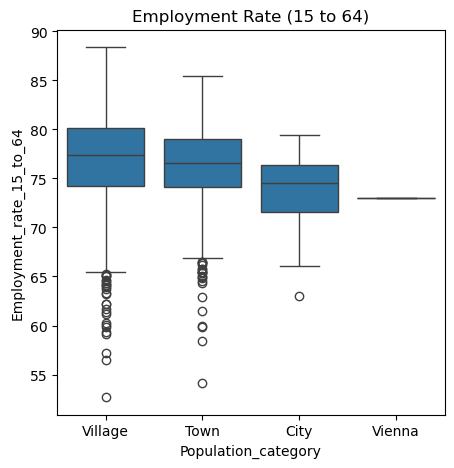

Employment_rate_15_to_64 ANOVA:
                           sum_sq      df       F    PR(>F)
Population_category    460.163910     3.0  8.2653  0.000018
Residual             40883.417132  2203.0     NaN       NaN


Statistically significant!


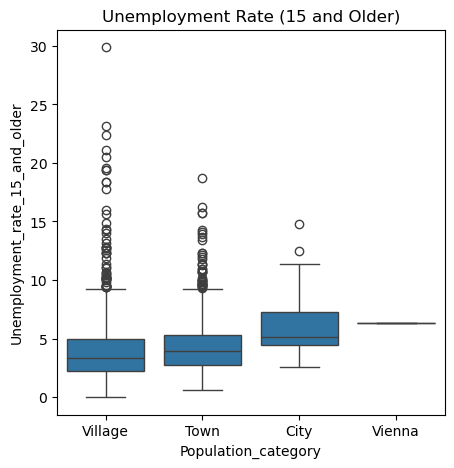

Unemployment_rate_15_and_older ANOVA:
                           sum_sq      df         F    PR(>F)
Population_category    146.343258     3.0  7.158743  0.000088
Residual             15011.675718  2203.0       NaN       NaN


Statistically significant!


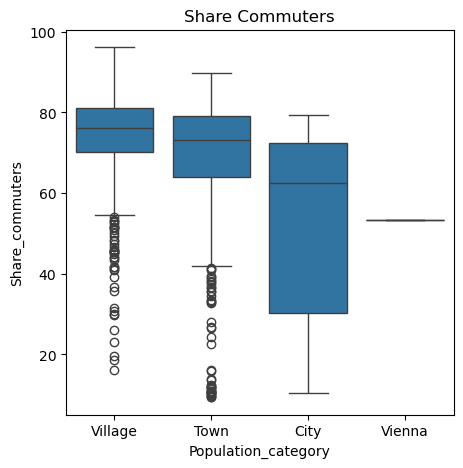

Share_commuters ANOVA:
                            sum_sq      df          F        PR(>F)
Population_category   20900.024858     3.0  45.419226  1.779789e-28
Residual             337909.436257  2203.0        NaN           NaN




Statistically significant!


In [72]:
print('Employment and labor market')
# Set global parameters for chart size
plt.rcParams['figure.figsize'] = (5, 5) 
# Set significance level for test
significance_level = 0.05

# Employment rate boxplot
sns.boxplot(x='Population_category', y='Employment_rate_15_to_64', data=AustriaCensus2019)
plt.title('Employment Rate (15 to 64)')
plt.show()
# Employment rate ANOVA
formula_employment_rate = 'Employment_rate_15_to_64 ~ Population_category'
model_employment_rate = ols(formula_employment_rate, data=AustriaCensus2019).fit()
aov_table_employment_rate = sm.stats.anova_lm(model_employment_rate, typ=2)
print("Employment_rate_15_to_64 ANOVA:")
print(aov_table_employment_rate)
#Check for statistical significance in ANOVA
print("\n")
p_value = aov_table_employment_rate['PR(>F)'][0]
if p_value < significance_level:
    print("Statistically significant!")
else:
    print("Not statistically significant.")

# Unemployment rate boxplot
sns.boxplot(x='Population_category', y='Unemployment_rate_15_and_older', data=AustriaCensus2019)
plt.title('Unemployment Rate (15 and Older)')
plt.show()
# Unemployment rate ANOVA
formula_unemployment_rate = 'Unemployment_rate_15_and_older ~ Population_category'
model_unemployment_rate = ols(formula_unemployment_rate, data=AustriaCensus2019).fit()
aov_table_unemployment_rate = sm.stats.anova_lm(model_unemployment_rate, typ=2)
print("Unemployment_rate_15_and_older ANOVA:")
print(aov_table_unemployment_rate)
#Check for statistical significance in ANOVA
print("\n")
p_value = aov_table_unemployment_rate['PR(>F)'][0]
if p_value < significance_level:
    print("Statistically significant!")
else:
    print("Not statistically significant.")

# Share commuters boxplot
sns.boxplot(x='Population_category', y='Share_commuters', data=AustriaCensus2019)
plt.title('Share Commuters')
plt.show()
# Share_commuters ANOVA
formula_commuters = 'Share_commuters ~ Population_category'
model_commuters = ols(formula_commuters, data=AustriaCensus2019).fit()
aov_table_commuters = sm.stats.anova_lm(model_commuters, typ=2)
print("Share_commuters ANOVA:")
print(aov_table_commuters)
print("\n")
#Check for statistical significance in ANOVA
print("\n")
p_value = aov_table_commuters['PR(>F)'][0]
if p_value < significance_level:
    print("Statistically significant!")
else:
    print("Not statistically significant.")



_3.2 Education_

__Share of People with Secondary Education__
Villages have the highest mean percentage of residents with secondary education, surpassing towns, cities, and Vienna. Towns and cities exhibit slightly higher variability compared to villages. The ANOVA results shows a statistically significant disparity in the share of residents with secondary education across municipalities (p-value < 0.05).

__Share of People with Tertiary Education__
Tertiary education increases from villages to cities, with towns showing the highest variability. ANOVA results highlight a statistically significant difference in tertiary education across municipalities (p-value < 0.05), indicating distinct educational patterns among the municipalities.


Education


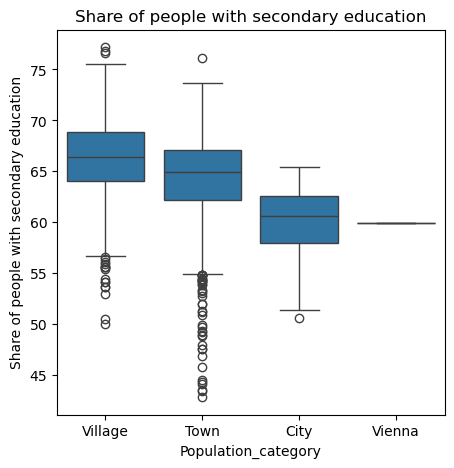

Share_of_people_with_secondary_education ANOVA:
                           sum_sq      df          F        PR(>F)
Population_category   2926.669112     3.0  55.953676  7.457291e-35
Residual             38409.463666  2203.0        NaN           NaN


Statistically significant!


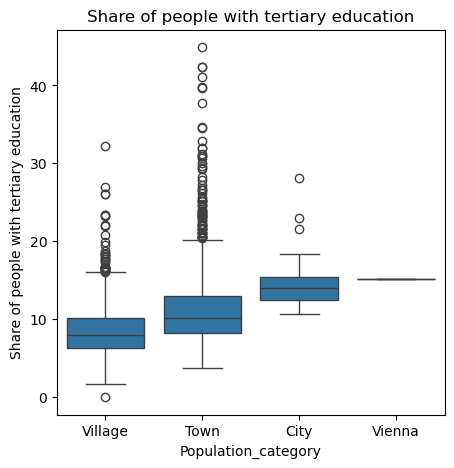

Share_of_people_with_tertiary_education ANOVA:
                           sum_sq      df          F        PR(>F)
Population_category   4891.151257     3.0  82.428534  1.533186e-50
Residual             43573.932776  2203.0        NaN           NaN


Statistically significant!


In [73]:
print('Education')

# Share secondary education boxplot
sns.boxplot(x='Population_category', y='Share of people with secondary education', data=AustriaCensus2019)
plt.title('Share of people with secondary education')
plt.show()
# Share_of_people_with_secondary_education ANOVA
formula_secondary_education = 'Q("Share of people with secondary education") ~ Population_category'
model_secondary_education = ols(formula_secondary_education, data=AustriaCensus2019).fit()
aov_table_secondary_education = sm.stats.anova_lm(model_secondary_education, typ=2)
print("Share_of_people_with_secondary_education ANOVA:")
print(aov_table_secondary_education)
#Check for statistical significance in ANOVA
print("\n")
p_value = aov_table_secondary_education['PR(>F)'][0]
if p_value < significance_level:
    print("Statistically significant!")
else:
    print("Not statistically significant.")




# Share tertiary education boxplot
sns.boxplot(x='Population_category', y='Share of people with tertiary education', data=AustriaCensus2019)
plt.title('Share of people with tertiary education')
plt.show()
# Share_of_people_with_tertiary_education ANOVA
formula_tertiary_education = 'Q("Share of people with tertiary education") ~ Population_category'
model_tertiary_education = ols(formula_tertiary_education, data=AustriaCensus2019).fit()
aov_table_tertiary_education = sm.stats.anova_lm(model_tertiary_education, typ=2)
print("Share_of_people_with_tertiary_education ANOVA:")
print(aov_table_tertiary_education)
#Check for statistical significance in ANOVA
print("\n")
p_value = aov_table_tertiary_education['PR(>F)'][0]
if p_value < significance_level:
    print("Statistically significant!")
else:
    print("Not statistically significant.")


_3.3 Demographics_

__Average Household Size__
Villages have the largest mean household size, while towns, cities, and Vienna exhibit smaller average sizes. ANOVA results confirm a statistically significant difference in average household size across population categories (p-value < 0.05).

__Proportion 65 and Older__
Means are similar across all categories, and the ANOVA results do not show a statistically significant difference (p-value > 0.05).

__Proportion Under 15__
Means are similar across all categories, and the ANOVA results do not show a statistically significant difference (p-value > 0.05).

__Share of Non-Austrian Citizens__
There is a notable increase in mean values from villages to cities. Surprisingly, Vienna has a slightly lower percentage of non-Austrian citizens (16.6%) compared to other cities (17.82%). ANOVA results highlight a statistically significant difference in the share of non-Austrian citizens across population categories (p-value < 0.05).

Demographics


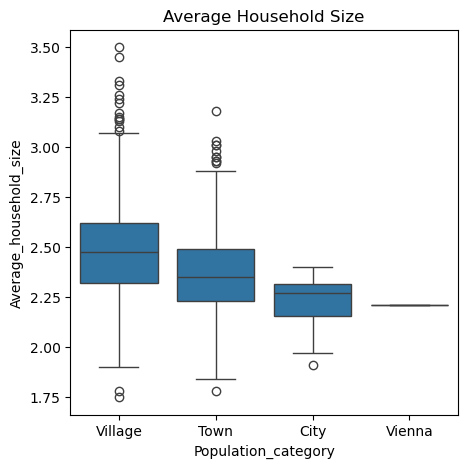

Average_household_size ANOVA:
                         sum_sq      df          F        PR(>F)
Population_category    8.765742     3.0  63.207975  3.354643e-39
Residual             101.838039  2203.0        NaN           NaN




Statistically significant!


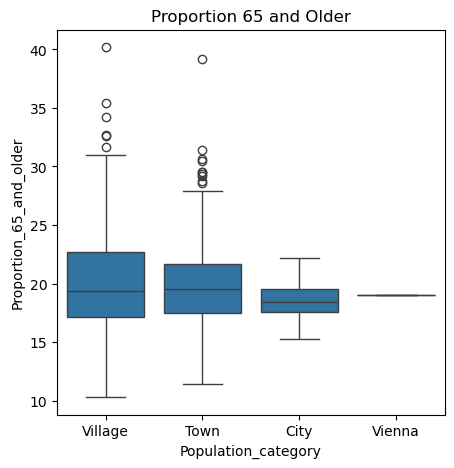

Proportion_65_and_older ANOVA:
                           sum_sq      df        F    PR(>F)
Population_category     86.773922     3.0  2.22183  0.083675
Residual             28679.498222  2203.0      NaN       NaN




Not statistically significant.


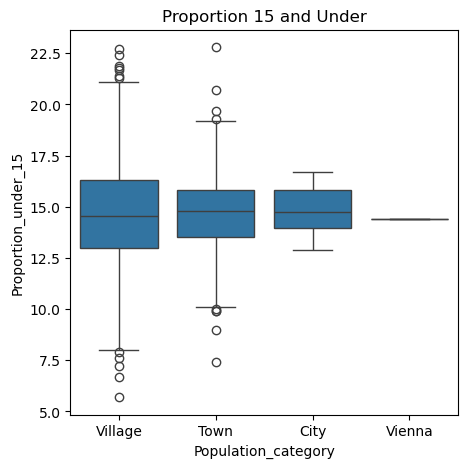

Proportion_15 and under ANOVA:
                           sum_sq      df         F    PR(>F)
Population_category      4.844526     3.0  0.349731  0.789354
Residual             10172.084446  2203.0       NaN       NaN




Not statistically significant.


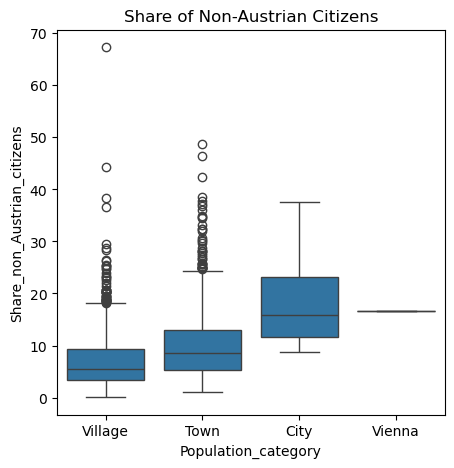

Share_non_Austrian_citizens ANOVA:
                           sum_sq      df          F        PR(>F)
Population_category   7057.384380     3.0  65.717762  1.072249e-40
Residual             78859.542135  2203.0        NaN           NaN


Statistically significant!


In [74]:
print('Demographics')

# Average household size boxplot
sns.boxplot(x='Population_category', y='Average_household_size', data=AustriaCensus2019)
plt.title('Average Household Size')
plt.show()
# Average_household_size ANOVA
formula_household_size = 'Average_household_size ~ Population_category'
model_household_size = ols(formula_household_size, data=AustriaCensus2019).fit()
aov_table_household_size = sm.stats.anova_lm(model_household_size, typ=2)
print("Average_household_size ANOVA:")
print(aov_table_household_size)
print("\n")
#Check for statistical significance in ANOVA
print("\n")
p_value = aov_table_household_size['PR(>F)'][0]
if p_value < significance_level:
    print("Statistically significant!")
else:
    print("Not statistically significant.")



# Proportion 65 and older boxplot
sns.boxplot(x='Population_category', y='Proportion_65_and_older', data=AustriaCensus2019)
plt.title('Proportion 65 and Older')
plt.show()
# Proportion_65_and_older ANOVA
formula_65_and_older = 'Proportion_65_and_older ~ Population_category'
model_65_and_older = ols(formula_65_and_older, data=AustriaCensus2019).fit()
aov_table_65_and_older = sm.stats.anova_lm(model_65_and_older, typ=2)
print("Proportion_65_and_older ANOVA:")
print(aov_table_65_and_older)
print("\n")
#Check for statistical significance in ANOVA
print("\n")
p_value = aov_table_65_and_older['PR(>F)'][0]
if p_value < significance_level:
    print("Statistically significant!")
else:
    print("Not statistically significant.")


# Proportion 15 and under boxplot
sns.boxplot(x='Population_category', y='Proportion_under_15', data=AustriaCensus2019)
plt.title('Proportion 15 and Under')
plt.show()
formula_under_15 = 'Proportion_under_15 ~ Population_category'
model_under_15 = ols(formula_under_15, data=AustriaCensus2019).fit()
aov_table_under_15 = sm.stats.anova_lm(model_under_15, typ=2)
print("Proportion_15 and under ANOVA:")
print(aov_table_under_15)
print("\n")
#Check for statistical significance in ANOVA
print("\n")
p_value = aov_table_under_15['PR(>F)'][0]
if p_value < significance_level:
    print("Statistically significant!")
else:
    print("Not statistically significant.")


# Share non-Austrian citizens boxplot
sns.boxplot(x='Population_category', y='Share_non_Austrian_citizens', data=AustriaCensus2019)
plt.title('Share of Non-Austrian Citizens')
plt.show()
# Share_non_Austrian_citizens ANOVA
formula_non_Austrian_citizens = 'Share_non_Austrian_citizens ~ Population_category'
model_non_Austrian_citizens = ols(formula_non_Austrian_citizens, data=AustriaCensus2019).fit()
aov_table_non_Austrian_citizens = sm.stats.anova_lm(model_non_Austrian_citizens, typ=2)
print("Share_non_Austrian_citizens ANOVA:")
print(aov_table_non_Austrian_citizens)
#Check for statistical significance in ANOVA
print("\n")
p_value = aov_table_non_Austrian_citizens['PR(>F)'][0]
if p_value < significance_level:
    print("Statistically significant!")
else:
    print("Not statistically significant.")



4. Examining Unique Cases
----------------------
Finally I concluded my analysis by examining some unique outlier cases. 

__Municipality with the Smallest Population (Gramais, Tyrol)__

Gramais stands out as the smallest municipality with a population of merely 42 residents.

__Municipality with the Largest Amount of Non-Austrians (Jungholz, Tyrol)__

Jungholz holds the record for the highest proportion of non-Austrian citizens (67.3%) among Austrian municipalities, attributed to its unique geographic position as an exclave surrounded by Germany.

__Municipality with the Most Unemployment (Galtür, Tyrol)__

Galtür, a small ski resort town with a population of 765, exhibits the highest unemployment rate (29.9%). The prevalence of seasonal employment, as indicated by a higher proportion of residents under 15 (14.1%), aligns with the ski industry's dynamics. Surprisingly, the commuting rate out of the municipality is relatively low (41.2%).


In [75]:
#Case analysis

print("Case Analysis")
print("\n\n")
#Smallest Population
# Find cases with highest and lowest values for each column
min_values_pop = AustriaCensus2019['Total_population'].idxmin()
# Display results
min_cases_pop = AustriaCensus2019.loc[min_values_pop]
print("Municipality with the Smallest Population")
print(min_cases_pop)
print("\n\n")
#Non-Austrians
# Find cases with highest and lowest values for each column
max_values_non_Austrian = AustriaCensus2019['Share_non_Austrian_citizens'].idxmax()
# Display results
max_cases_non_Austrian = AustriaCensus2019.loc[max_values_non_Austrian]
print("Municipality with the Largest Amount of Non-Austrians")
print(max_cases_non_Austrian)
print("\n\n")
# Unemployment
# Find cases with highest and lowest values for each column
max_values_Unemployment = AustriaCensus2019['Unemployment_rate_15_and_older'].idxmax()
# Display results
max_cases_Unemployment = AustriaCensus2019.loc[max_values_Unemployment]
print("Municipality with the Most Unemployment")
print(max_cases_Unemployment)



Case Analysis



Municipality with the Smallest Population
Code                                          70812
District                                    Gramais
Total_population                                 42
Proportion_under_15                            11.9
Proportion_65_and_older                        26.2
Share_non_Austrian_citizens                    14.3
Employment_rate_15_to_64                       69.2
Unemployment_rate_15_and_older                  0.0
Share of people with secondary education       54.1
Share of people with tertiary education        10.8
Share_commuters                                63.2
Number_private_households                        17
Average_household_size                         2.47
Number of families                               13
Companies                                         7
Workplaces                                        7
Number_of_employees                              13
Population_category                         Village
Name:


5. Conclusion and Discussion
----------------------


This study, utilizing data from the 2019 census across more than 2,000 municipalities, revealed statistically significant differences in mean employment, unemployment, commuting patterns, the proportion of residents with non-Austrian citizenship, and educational attainment levels across population categories. I found that Villages and towns exhibit higher employment rates, while cities, including Vienna, face elevated unemployment. Educational patterns reveal villages as leaders in secondary education, while larger urban municipalities have higher tertiary education. Demographic differences manifest in larger average household sizes in villages and an increased presence of non-Austrian citizens in cities. Examining unique cases, such as Gramais, Jungholz, and Galtür, adds depth to the understanding of Austria's diverse municipal landscape. 

This analysis reveals the diverse economic, demographic, and social landscapes within Austria's municipalities, providing an enriched understanding of everyday life in the country.